In [4]:
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import os

# === Data Loading and Processing ===

def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def prepare_date_features(articles):
    months = np.array([a['month'] for a in articles])
    weekdays = np.array([a['day_of_week'] for a in articles])
    hours = np.array([a['hour'] for a in articles])

    month_sin = np.sin(2 * np.pi * months / 12)
    month_cos = np.cos(2 * np.pi * months / 12)
    weekday_sin = np.sin(2 * np.pi * weekdays / 7)
    weekday_cos = np.cos(2 * np.pi * weekdays / 7)
    hour_sin = np.sin(2 * np.pi * hours / 24)
    hour_cos = np.cos(2 * np.pi * hours / 24)

    return np.stack([month_sin, month_cos, weekday_sin, weekday_cos, hour_sin, hour_cos], axis=1)



def extract_topics_from_urls(urls):
    topics, subtopics = [], []
    for url in urls:
        parts = url.split('/')
        topic = parts[3] if len(parts) > 3 else 'none'
        subtopic = parts[4] if len(parts) > 4 else 'none'
        subtopic = 'none' if subtopic == 'NO_SUBTOPIC' else subtopic
        topics.append(topic)
        subtopics.append(subtopic)
    return topics, subtopics

# === Dataset and Model Definitions ===

class NewsDataset(Dataset):
    def __init__(self, bert, topic, subtopic, date, target):
        self.bert = bert
        self.topic = topic
        self.subtopic = subtopic
        self.date = date
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.bert[idx], self.topic[idx], self.subtopic[idx], self.date[idx], self.target[idx]

class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, n_topics, n_subtopics):
        super().__init__()
        self.topic_emb = nn.Embedding(n_topics, 16)
        self.subtopic_emb = nn.Embedding(n_subtopics, 24)
        self.net = nn.Sequential(
            nn.Linear(input_dim + 16 + 24 + 6, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.25),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, 1),
            nn.Softplus()
        )

    def forward(self, x, t, st, d):
        t_emb = self.topic_emb(t)
        st_emb = self.subtopic_emb(st)
        return self.net(torch.cat([x, t_emb, st_emb, d], dim=1))

# === Trainer and Predictor ===

class RTVPredictor:
    def __init__(self, model_id=0, batch_size=150, epochs=150, lr=1e-4, weight_decay=1e-3):
        self.model_id = model_id
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.weight_decay = weight_decay
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def prepare(self, articles):
        for a in articles:
            dt = pd.to_datetime(a['date'])
            a['year'] = dt.year
            a['month'] = dt.month
            a['day_of_week'] = dt.weekday()
            a['hour'] = dt.hour

    def train(self, train_articles, bert_vectors, save_path):
        self.prepare(train_articles)

        targets = np.log1p([a['n_comments'] for a in train_articles])
        topics, subtopics = extract_topics_from_urls([a['url'] for a in train_articles])

        self.topic_enc = LabelEncoder().fit(topics)
        self.subtopic_enc = LabelEncoder().fit(subtopics)

        topic_ids = self.topic_enc.transform(topics)
        subtopic_ids = self.subtopic_enc.transform(subtopics)
        date_feats = prepare_date_features(train_articles)


        X_train, X_val, topic_train, topic_val, subtopic_train, subtopic_val, date_train, date_val, y_train, y_val = train_test_split(
            bert_vectors, topic_ids, subtopic_ids, date_feats, targets, test_size=0.05, random_state=42
        )

        train_data = NewsDataset(
            torch.tensor(X_train).float(), torch.tensor(topic_train).long(),
            torch.tensor(subtopic_train).long(), torch.tensor(date_train).float(),
            torch.tensor(y_train).float()
        )
        val_data = NewsDataset(
            torch.tensor(X_val).float(), torch.tensor(topic_val).long(),
            torch.tensor(subtopic_val).long(), torch.tensor(date_val).float(),
            torch.tensor(y_val).float()
        )

        loader_train = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        loader_val = DataLoader(val_data, batch_size=self.batch_size)

        model = MLPWithEmbeddings(X_train.shape[1], len(self.topic_enc.classes_), len(self.subtopic_enc.classes_)).to(self.device)
        opt = torch.optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=5)
        loss_fn = nn.L1Loss()

        best_loss = float('inf')
        patience = 15
        no_improve = 0

        for epoch in range(self.epochs):
            model.train()
            for x, t, st, d, y in loader_train:
                opt.zero_grad()
                y_hat = model(x.to(self.device), t.to(self.device), st.to(self.device), d.to(self.device)).squeeze()
                loss = loss_fn(y_hat, y.to(self.device))
                loss.backward()
                opt.step()

            model.eval()
            losses = []
            with torch.no_grad():
                for x, t, st, d, y in loader_val:
                    y_hat = model(x.to(self.device), t.to(self.device), st.to(self.device), d.to(self.device)).squeeze()
                    losses.append(loss_fn(y_hat, y.to(self.device)).item())
            val_loss = np.mean(losses)
            scheduler.step(val_loss)
            print(f"Epoch {epoch+1:03d} - Val Loss: {val_loss:.4f}")

            if val_loss < best_loss - 1e-4:
                best_loss = val_loss
                no_improve = 0
                best_state = model.state_dict()
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"⏹️ Early stopping at epoch {epoch+1}")
                    break

        self.model = model
        torch.save(best_state, save_path)

    def load(self, path, bert_dim):
        self.model = MLPWithEmbeddings(bert_dim, len(self.topic_enc.classes_), len(self.subtopic_enc.classes_)).to(self.device)
        self.model.load_state_dict(torch.load(path))

    def predict(self, articles, bert_vectors):
        self.prepare(articles)
        topics, subtopics = extract_topics_from_urls([a['url'] for a in articles])
        topic_ids = [t if t in self.topic_enc.classes_ else self.topic_enc.classes_[0] for t in topics]
        subtopic_ids = [s if s in self.subtopic_enc.classes_ else self.subtopic_enc.classes_[0] for s in subtopics]

        date_feats = prepare_date_features(articles)

        x = torch.tensor(bert_vectors).float().to(self.device)
        t = torch.tensor(self.topic_enc.transform(topic_ids)).long().to(self.device)
        st = torch.tensor(self.subtopic_enc.transform(subtopic_ids)).long().to(self.device)
        d = torch.tensor(date_feats).float().to(self.device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(x, t, st, d).squeeze().cpu().numpy()
        return np.clip(np.expm1(preds), 0, None)

def ensemble_predict(n=10):
    # === Load data ===
    train_data = load_json("../data/rtvslo_train.json")
    val_data = load_json("../data/rtvslo_test.json")
    bert_val = torch.load("../embeddings/sloberta_embeddings_test.pt").numpy()

    # === Fit encoders on training data ===
    topics, subtopics = extract_topics_from_urls([a['url'] for a in train_data])
    topic_enc = LabelEncoder().fit(topics)
    subtopic_enc = LabelEncoder().fit(subtopics)

    # === Prepare model inputs ===
    for a in train_data + val_data:
        dt = pd.to_datetime(a["date"])
        a["year"] = dt.year
        a["month"] = dt.month
        a["day_of_week"] = dt.weekday()
        a["hour"] = dt.hour

    # === Collect model paths ===
    model_paths = sorted(os.listdir("../best_models"))[:n]
    model_paths = [os.path.join("../best_models", p) for p in model_paths if p.endswith(".pt")]

    assert len(model_paths) == n, f"Expected {n} models, found {len(model_paths)}"

    # === Predict using each model and collect results ===
    all_preds = []

    for i, path in enumerate(model_paths):
        print(f"🔍 Loading model {i+1}/{n}: {os.path.basename(path)}")
        model = RTVPredictor()
        model.topic_enc = topic_enc
        model.subtopic_enc = subtopic_enc
        model.load(path, bert_val.shape[1])
        preds = model.predict(val_data, bert_val)
        all_preds.append(preds)

    # === Average predictions ===
    mean_preds = np.mean(all_preds, axis=0)
    np.savetxt("ensemble_predictions_test.txt", mean_preds, fmt="%.4f")
    print("✅ Saved mean ensemble predictions to ensemble_predictions_test.txt")

# if __name__ == "__main__":
#     ensemble_predict(n=3)

In [7]:
import shap
import matplotlib.pyplot as plt

class SHAPWrapper:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device
        self.model.eval()

    def __call__(self, X):
        bert_dim = 768  # Update this if your embeddings are a different size
        topic_dim = 1
        subtopic_dim = 1
        date_dim = 6

        bert = torch.tensor(X[:, :bert_dim]).float().to(self.device)
        topic = torch.tensor(X[:, bert_dim:bert_dim + topic_dim]).long().squeeze().to(self.device)
        subtopic = torch.tensor(X[:, bert_dim + topic_dim:bert_dim + topic_dim + subtopic_dim]).long().squeeze().to(self.device)
        date = torch.tensor(X[:, -date_dim:]).float().to(self.device)

        with torch.no_grad():
            out = self.model(bert, topic, subtopic, date).squeeze().cpu().numpy()
        return out

# === Load data and model ===
val_data = load_json("../data/rtvslo_test.json")
bert_val = torch.load("../embeddings/sloberta_embeddings_test.pt").numpy()

# Prepare date, topic/subtopic
for a in val_data:
    dt = pd.to_datetime(a["date"])
    a["year"] = dt.year
    a["month"] = dt.month
    a["day_of_week"] = dt.weekday()
    a["hour"] = dt.hour

topics, subtopics = extract_topics_from_urls([a['url'] for a in val_data])
topic_enc = LabelEncoder().fit(topics)
subtopic_enc = LabelEncoder().fit(subtopics)

topic_ids = topic_enc.transform(topics)
subtopic_ids = subtopic_enc.transform(subtopics)
date_feats = prepare_date_features(val_data)

# Stack all input features
X_shap = np.hstack([
    bert_val,
    topic_ids[:, None],
    subtopic_ids[:, None],
    date_feats
])

# Load model
model = RTVPredictor()
model.topic_enc = topic_enc
model.subtopic_enc = subtopic_enc
model.load("../best_models/model_rank01_mae26.0204.pt", bert_val.shape[1])  # Adjust model path as needed

# Create SHAP explainer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
shap_model = SHAPWrapper(model.model, device)

background = X_shap[np.random.choice(X_shap.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(shap_model, background)

# SHAP on a subset
shap_values = explainer.shap_values(X_shap[:50])  # Run on sample for speed

# Feature names
feature_names = [f"bert_{i}" for i in range(bert_val.shape[1])] + [
    "topic", "subtopic", "month_sin", "month_cos",
    "weekday_sin", "weekday_cos", "hour_sin", "hour_cos"
]

# Plot
shap.summary_plot(shap_values, X_shap[:50], feature_names=feature_names, show=True)


/tmp/ipykernel_4536/2170423467.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bert_val = torch.load("../embeddings/sloberta_embeddings_test.pt").numpy()
/tmp/ipykernel

RuntimeError: Error(s) in loading state_dict for MLPWithEmbeddings:
	size mismatch for subtopic_emb.weight: copying a param with shape torch.Size([12347, 24]) from checkpoint, the shape in current model is torch.Size([501, 24]).

In [30]:
import numpy as np
import json
from sklearn.metrics import mean_absolute_error

# 1. Load your predictions
preds = np.loadtxt("adj_predictions.txt")

# 2. Load your true y-values from dataset_val.json
with open("../data/rtvslo_validation.json", "r", encoding="utf-8") as f:
    val_articles = json.load(f)

# 3. Extract true n_comments
y_true = np.array([a["n_comments"] for a in val_articles], dtype=np.float32)

# 4. Check lengths
assert len(preds) == len(y_true), f"Length mismatch: preds={len(preds)}, y_true={len(y_true)}"

# 5. Calculate MAE
mae = mean_absolute_error(y_true, preds)

print(f"📊 MAE between predictions and true values: {mae:.2f}")

📊 MAE between predictions and true values: 25.59


In [29]:
import numpy as np
import json
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- 1. Load ---
preds = np.loadtxt("ensemble_predictions_val.txt")

# --- 2. Postprocessing: Quantile Smoothing ---

# Step 1: Clip extreme values
max_allowed = 3000
preds = np.clip(preds, 0, max_allowed)

# Step 2: Quantile smoothing
q_low = np.percentile(preds, 1)
q_high = np.percentile(preds, 99)

# Linearly squash very small and very large predictions
def quantile_smooth(x):
    if x < q_low:
        return x * 0.7  # shrink low values
    elif x > q_high:
        return q_high # shrink heavy tails
    else:
        return x

vectorized_smooth = np.vectorize(quantile_smooth)
smoothed_preds = vectorized_smooth(preds)

# --- 3. Save ---
np.savetxt("adj_predictions.txt", smoothed_preds, fmt="%.4f")

print("✅ Saved adj_predictions.txt with quantile smoothing.")

✅ Saved adj_predictions.txt with quantile smoothing.


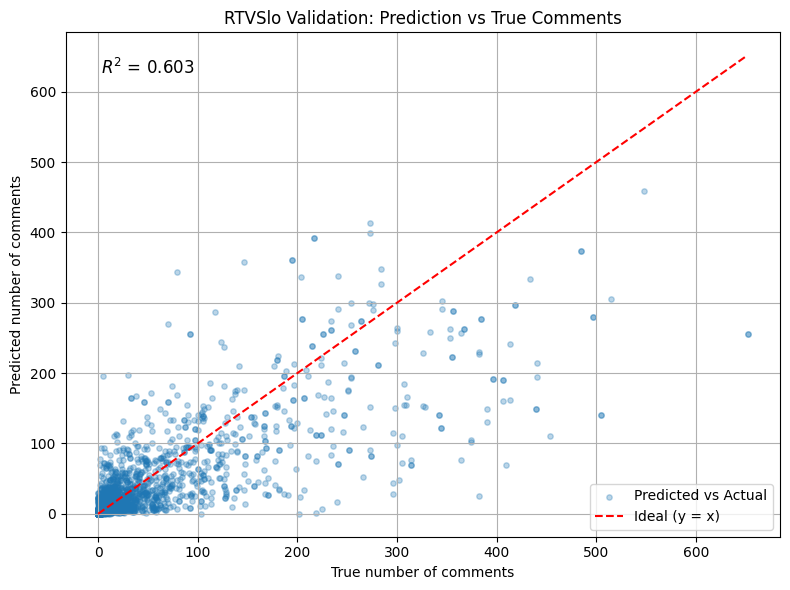

In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Load true values
with open("../data/rtvslo_validation.json", "r", encoding="utf-8") as f:
    val_articles = json.load(f)
y_true = np.array([a["n_comments"] for a in val_articles])

# Load predictions
y_pred = np.loadtxt("ensemble_predictions_val.txt")

# Optional: sort both if you want a diagonal alignment plot
# idx = np.argsort(y_true)
# y_true = y_true[idx]
# y_pred = y_pred[idx]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.3, s=15, label="Predicted vs Actual")
plt.plot([0, max(y_true)], [0, max(y_true)], 'r--', label="Ideal (y = x)")
plt.xlabel("True number of comments")
plt.ylabel("Predicted number of comments")
plt.title("RTVSlo Validation: Prediction vs True Comments")
plt.legend()
plt.grid(True)

# R² score (optional)
r2 = r2_score(y_true, y_pred)
plt.text(0.05, 0.95, f"$R^2$ = {r2:.3f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig("prediction_vs_real.png", dpi=300)
plt.show()
